# IMDB Dataset of 50K Movie Reviews NLP project

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_colwidth = 2000

import re
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, FreqDist

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression,  SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix

from lightgbm import LGBMClassifier

import pickle

In [6]:
df = pd.read_csv(r'D:\Big_Blue\IMDB_Dataset.csv')
df

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

## Exploratory Data Analysis

In [7]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

#### We have a balanced dataset

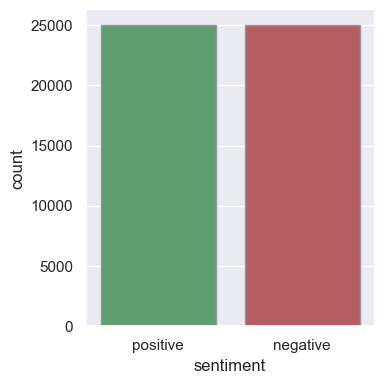

In [20]:
my_pal = {"positive": "g", "negative": "r"}

sns.catplot(data=df, x='sentiment', kind="count", palette=my_pal, edgecolor=".6", height=4)
None

In [21]:
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

#### Lets see if there is a difference in word count for each sentiment

In [22]:
df["review_word_length"] = df["review"].apply(lambda x: len(x.split(' '))) # how many words in each review

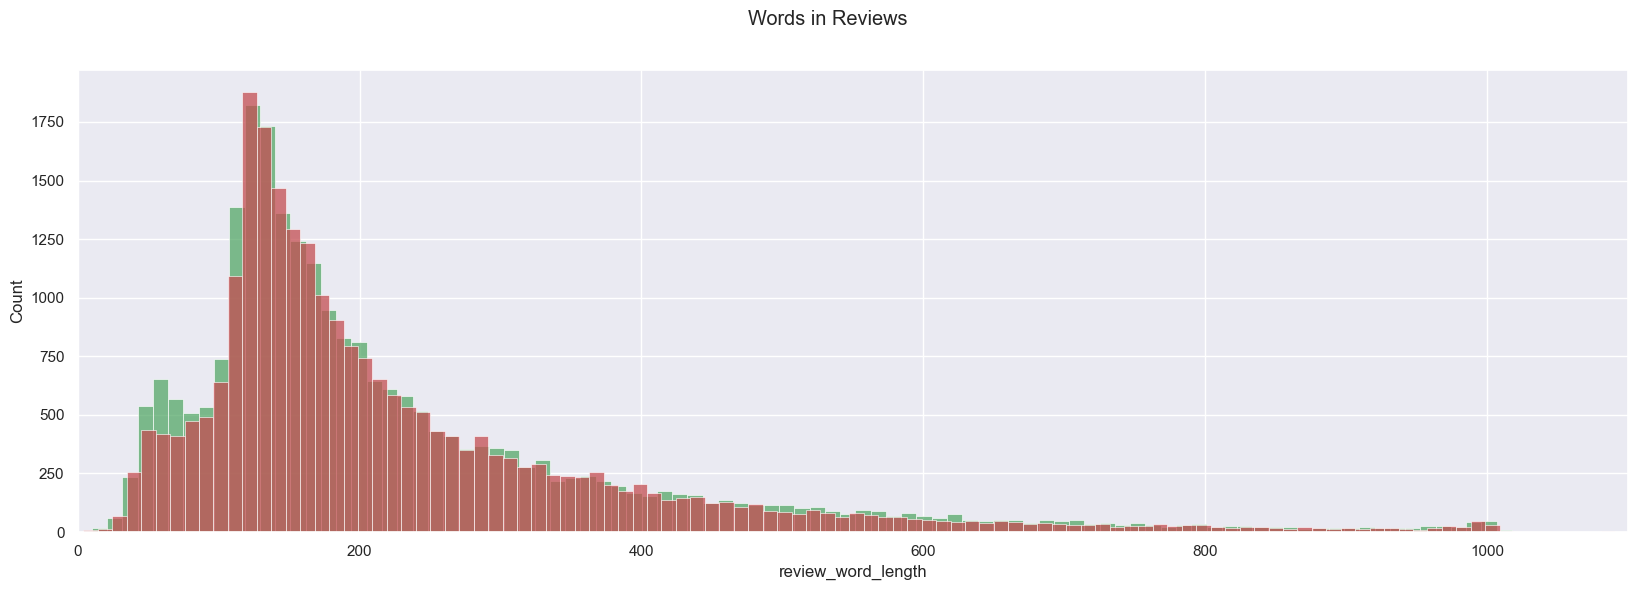

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))

review_len_pos=df[df["sentiment"]=="positive"]["review_word_length"]
sns.histplot(ax=ax, x=review_len_pos, color='g')

review_len_neg=df[df["sentiment"]=="negative"]["review_word_length"]
sns.histplot(ax=ax, x=review_len_neg,  color='r')

ax.set_xlim([0, 1100])
fig.suptitle("Words in Reviews")

plt.show()

#### Detect outliers

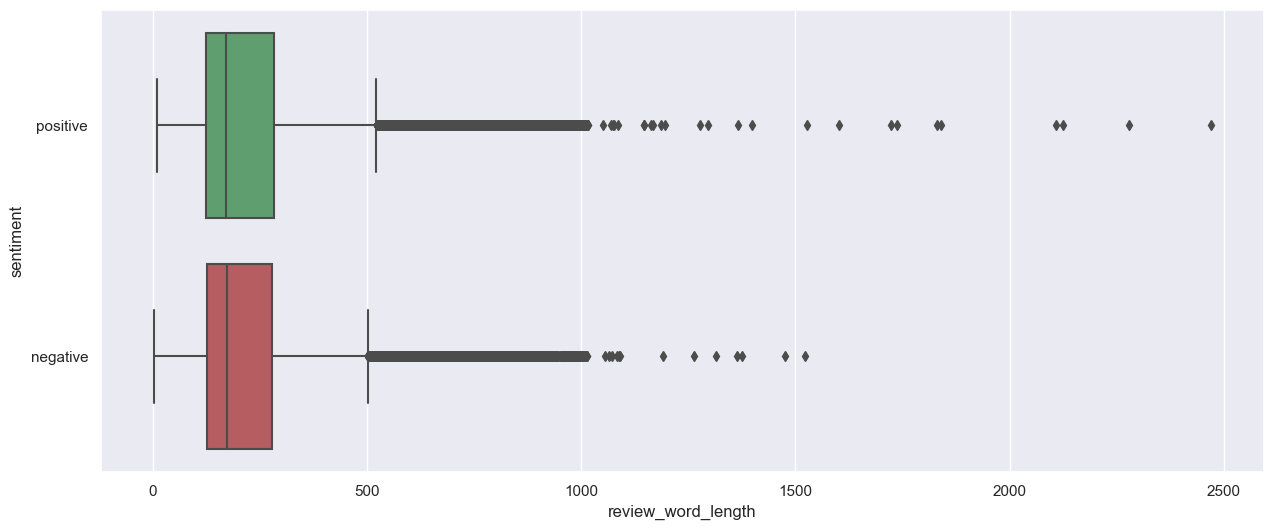

In [27]:
plt.figure(figsize =(15, 6))
sns.boxplot(data=df, x='review_word_length', y='sentiment', palette=my_pal)
None

In [9]:
df = df.drop('review_word_length', 1)

## Preprocessing

## How to process the data:
    1. Lower the letters
    2. Remove HTML format e.g. <br /><br />
    3. Remove urls
    4. Keep characters and spaces only

In [30]:
df.head()

,review,sentiment,review_word_length
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive,307
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive,162
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive,166
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides t

In [31]:
def data_cleaning(df):
    
    df['review'] = df['review'].str.lower()
    df['review'] = df['review'].str.replace('<.*>', ' ') # remove html format
    df['review'] = df["review"].str.replace('https?://\S+|www\.\S+',' ') # remove urls
    df["review"] = df['review'].str.replace('[^a-z ]',' ') # keep characters and spaces
    df['review'] = df['review'].str.replace(' . ',' ') # remove single character between spaces
    df['review'] = df['review'].str.replace('\s+',' ').str.strip() # multiple spaces to one and remove side spaces

    return df

In [32]:
df = data_cleaning(df)
df.head()

,review,sentiment,review_word_length
0,one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare forget pretty pictures painted for mainstream audiences forget charm forget romance oz doesn mess around the first episode ever saw struck me as so nasty it was surreal couldn say was ready for it but as watched more developed taste for oz and got accustomed to the high levels of graphic violence not just violence but injustice crooked guards who ll be sold out for nickel inmates who ll kill on order and get away with it well mannered middle class inmates being turned into prison bitches due to their lack of street skills or prison experience watching oz you may become comfortable with what is uncomfortable viewing thats if you can get in touch with your darker side,positive,307
1,a wonderful little production the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwell murals decorating every surface are terribly well done,positive,162
2,i thought this was wonderful way to spend time on too hot summer weekend sitting in the air conditioned theater and watching light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point risk addiction thought it was proof that woody allen is still fully in control of the style many of us have grown to love this may not be the crown jewel of his career but it was wittier than devil wears prada and more interesting than superman great comedy to go see with friends,positive,166
3,basically there a family where little boy jake thinks there a zombie in his closet his parents are fighting all the time out of just for the well playing parents descent dialogs as for the shots with jake just ignore them,negative,138
4,petter mattei love in the time of money is visually stunning film to watch mr mattei offers us vivid portrait about human relations this is movie that seems to be telling us what money power and success do to people in the different situations we encounter we wish mr mattei good luck and await anxiously for his next work,positive,230


### Now that we have clean text lets look at the most frequent words

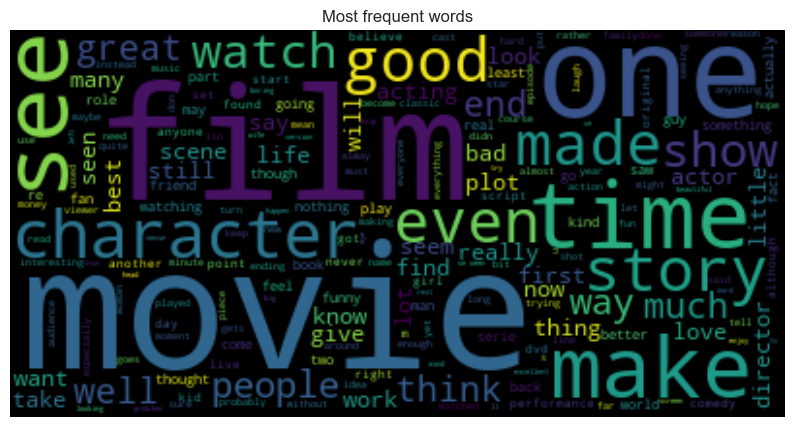

In [33]:
# Combine text

word_picture = " ".join(tweet for tweet in df.review)

# Create and generate wordcloud

wordcloud = WordCloud().generate(word_picture)

#Display the image

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words')
plt.show()

## Lets create some functions to remove stopwords and keep certain words based on their parts of speach categories

#### Stopwords, Lemmatization Nouns, Tokenization,  POS Nouns

In [34]:
def prepro_n(df):
    
    stop = stopwords.words('english')
    df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    lmtzr = WordNetLemmatizer()
    df['review'] = df['review'].apply(lambda x: ' '.join([lmtzr.lemmatize(word) for word in x.split()]))
    
    df['review'] = df['review'].str.split(" ")
    
    df['review'] = df['review'].apply(nltk.pos_tag)
    df['review'] = df['review'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])
    
    df['review'] = df['review'].apply(lambda x: ' '.join(x))

    df["sentiment"] = df["sentiment"].replace({"positive":1, "negative":0})

    return df

#### Stopwords, Lemmatization Nouns, Verbs, Adjectives, Tokenization, POS Nouns, Adverbs, Adjectives

In [36]:
def prepro_lnaa_pnaa(df):
    
    stop = stopwords.words('english')
    df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    lmtzr = WordNetLemmatizer()
    df['review'] = df['review'].apply(lambda x: ' '.join([lmtzr.lemmatize(word, 'n') for word in x.split()]))
    df['review'] = df['review'].apply(lambda x: ' '.join([lmtzr.lemmatize(word, 'a') for word in x.split()]))
    df['review'] = df['review'].apply(lambda x: ' '.join([lmtzr.lemmatize(word, 'v') for word in x.split()]))

    df['review'] = df['review'].str.split(" ")
    
    df['review'] = df['review'].apply(nltk.pos_tag)
    df['review'] = df['review'].apply(lambda x: [word for word, tag in x if tag in ["NN","NNS","NNP","NNPS","RB","RBR","RBS","JJ","JJR","JJS"]])
    
    df['review'] = df['review'].apply(lambda x: ' '.join(x))

    df["sentiment"] = df["sentiment"].replace({"positive":1, "negative":0})

    return df

#### Stopwords, Lemmatization Nouns, Tokenization

In [37]:
def prepro_ln_no_pos(df):
    
    stop = stopwords.words('english')
    df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    lmtzr = WordNetLemmatizer()
    df['review'] = df['review'].apply(lambda x: ' '.join([lmtzr.lemmatize(word) for word in x.split()]))
    
    df['review'] = df['review'].str.split(" ")
    
    df['review'] = df['review'].apply(lambda x: ' '.join(x))

    df["sentiment"] = df["sentiment"].replace({"positive":1, "negative":0})

    return df

## Classification Models 
#### For each one of our functions we will test a few models to find the best preprocessing method and classifier for our data
#### We will use accuracy as our metric since the dataset is balanced

In [45]:
scoring = {}

### POS with Nouns only

In [47]:
data = df.copy()
data = prepro_n(data)

In [48]:
X = data['review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
vectorizer = TfidfVectorizer(lowercase=False) 
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [50]:
clf_list = [
            LogisticRegression(),
            MultinomialNB(),
            RandomForestClassifier(n_jobs = -1),
            SGDClassifier(),
            LGBMClassifier()
           ] 

In [51]:
for clf in clf_list:
    
    clf.fit(X_train,y_train)

    print(clf)
    print('Train Score: ', clf.score(X_train,y_train))
    print('Test Score: ', clf.score(X_test,y_test))
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('\n')
    scoring[str(clf) + 'prepro_n'] = clf.score(X_test,y_test)

LogisticRegression()
Train Score:  0.843075
Test Score:  0.7756
[[3759 1202]
 [1042 3997]]


MultinomialNB()
Train Score:  0.851925
Test Score:  0.7791
[[3905 1056]
 [1153 3886]]


RandomForestClassifier(n_jobs=-1)
Train Score:  0.998925
Test Score:  0.7406
[[3694 1267]
 [1327 3712]]


SGDClassifier()
Train Score:  0.823
Test Score:  0.7738
[[3660 1301]
 [ 961 4078]]


LGBMClassifier()
Train Score:  0.78805
Test Score:  0.744
[[3537 1424]
 [1136 3903]]




### Lematization with Nouns, Verbs and Adjectives, POS with Nouns, Verbs and Adjectives

In [52]:
data = df.copy()
data = prepro_lnaa_pnaa(data)

In [53]:
X = data['review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
vectorizer = TfidfVectorizer(lowercase=False) 
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [55]:
clf_list = [
            LogisticRegression(),
            MultinomialNB(),
            RandomForestClassifier(n_jobs = -1),
            SGDClassifier(),
            LGBMClassifier()
           ] 

In [56]:
for clf in clf_list:
    
    clf.fit(X_train,y_train)

    print(clf)
    print('Train Score: ', clf.score(X_train,y_train))
    print('Test Score: ', clf.score(X_test,y_test))
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('\n')
    scoring[str(clf) + 'prepro_lnaa_pnaa'] = clf.score(X_test,y_test)

LogisticRegression()
Train Score:  0.898825
Test Score:  0.8509
[[4122  839]
 [ 652 4387]]


MultinomialNB()
Train Score:  0.886925
Test Score:  0.8385
[[4148  813]
 [ 802 4237]]


RandomForestClassifier(n_jobs=-1)
Train Score:  0.999425
Test Score:  0.8191
[[4050  911]
 [ 898 4141]]


SGDClassifier()
Train Score:  0.88945
Test Score:  0.8478
[[4070  891]
 [ 631 4408]]


LGBMClassifier()
Train Score:  0.853075
Test Score:  0.8193
[[3960 1001]
 [ 806 4233]]




## Stopwords, Lemmatization Nouns, Tokenization

In [57]:
data = df.copy()
data = prepro_ln_no_pos(data)

In [58]:
X = data['review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
vectorizer = TfidfVectorizer(lowercase=False) 
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [60]:
clf_list = [
            LogisticRegression(),
            MultinomialNB(),
            RandomForestClassifier(n_jobs = -1),
            SGDClassifier(),
            LGBMClassifier()
           ] 

In [61]:
for clf in clf_list:
    
    clf.fit(X_train,y_train)

    print(clf)
    print('Train Score: ', clf.score(X_train,y_train))
    print('Test Score: ', clf.score(X_test,y_test))
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('\n')
    scoring[str(clf) + 'prepro_ln_no_pos'] = clf.score(X_test,y_test)

LogisticRegression()
Train Score:  0.908625
Test Score:  0.8584
[[4173  788]
 [ 628 4411]]


MultinomialNB()
Train Score:  0.895925
Test Score:  0.8451
[[4197  764]
 [ 785 4254]]


RandomForestClassifier(n_jobs=-1)
Train Score:  0.99955
Test Score:  0.829
[[4097  864]
 [ 846 4193]]


SGDClassifier()
Train Score:  0.899075
Test Score:  0.8571
[[4139  822]
 [ 607 4432]]


LGBMClassifier()
Train Score:  0.860725
Test Score:  0.8285
[[3997  964]
 [ 751 4288]]




In [89]:
clf_scoring = pd.DataFrame(scoring.values(), scoring.keys()).rename(columns={0:'score'}).sort_values(by='score', ascending=False)
clf_scoring

,score
LogisticRegression()prepro_ln_no_pos,0.8584
SGDClassifier()prepro_ln_no_pos,0.8571
LogisticRegression()prepro_lnaa_pnaa,0.8509
SGDClassifier()prepro_lnaa_pnaa,0.8478
MultinomialNB()prepro_ln_no_pos,0.8451
MultinomialNB()prepro_lnaa_pnaa,0.8385
RandomForestClassifier(n_jobs=-1)prepro_ln_no_pos,0.8290
LGBMClassifier()prepro_ln_no_pos,0.8285
LGBMClassifier()prepro_lnaa_pnaa,0.8193
RandomForestClassifier(n_jobs=-1)prepro_lnaa_pnaa,0.8191


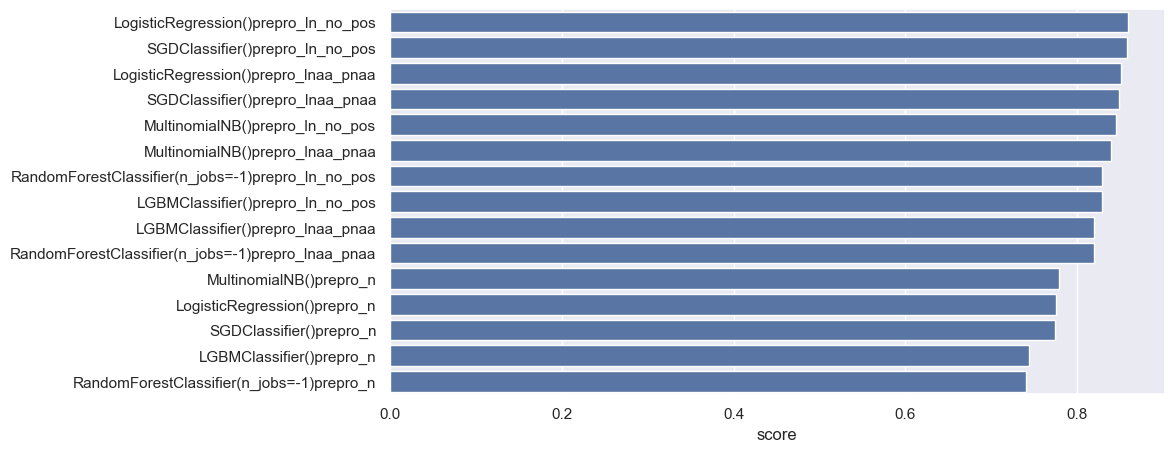

In [105]:
plt.figure(figsize=(10, 5))
sns.barplot(data=clf_scoring, x='score', y=clf_scoring.index, color='b')

None

In [108]:
scoring={}

### The best scores come without postagging. Lets do some hyperparameter tuning for our best models 
   ### (logistic regression, gradient descent) 

In [109]:
parameters = {
    
    'penalty' : ['l1', 'l2', 'elasticnet'],    
    'C' : [0.1, 1, 10],
    
            }

lr = GridSearchCV(LogisticRegression(n_jobs = -1, random_state = 0), parameters)
lr.fit(X_train, y_train)

print('LogisticRegression')
print('Best parameters: ', lr.best_params_)
print('Train Score: ', lr.score(X_train, y_train))
print('Test Score: ', lr.score(X_test, y_test))
print(confusion_matrix(y_test, lr.predict(X_test)))
print('\n')
scoring['Log_Reg'] = lr.score(X_test,y_test)

LogisticRegression
Best parameters:  {'C': 1, 'penalty': 'l2'}
Train Score:  0.908625
Test Score:  0.8584
[[4173  788]
 [ 628 4411]]




In [110]:
parameters = {
    
    'loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty' : ['l1', 'l2', 'elasticnet'],    
    'alpha' : [0.00001, 0.0001, 0.001]
    
            }

clf = GridSearchCV(SGDClassifier(n_jobs = -1, random_state = 0), parameters)
clf.fit(X_train, y_train)

print('SGDClassifier')
print('Best parameters: ', clf.best_params_)
print('Train Score: ', clf.score(X_train, y_train))
print('Test Score: ', clf.score(X_test, y_test))
print(confusion_matrix(y_test, clf.predict(X_test)))
print('\n')
scoring['SGD'] = clf.score(X_test,y_test)

SGDClassifier
Best parameters:  {'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'l2'}
Train Score:  0.936425
Test Score:  0.8612
[[4181  780]
 [ 608 4431]]




In [111]:
clf_scoring = pd.DataFrame(scoring.values(), scoring.keys()).rename(columns={0:'score'}).sort_values(by='score', ascending=False)
clf_scoring

,score
SGD,0.8612
Log_Reg,0.8584


### Lets save our SGD model

In [117]:
with open('D:\Big_Blue\data_challenge_4_best_nlp_model.pickle', 'wb') as files:
    pickle.dump(clf, files)

In [118]:
with open('D:\Big_Blue\data_challenge_4_best_nlp_model.pickle' , 'rb') as f:
    nlp_model = pickle.load(f)

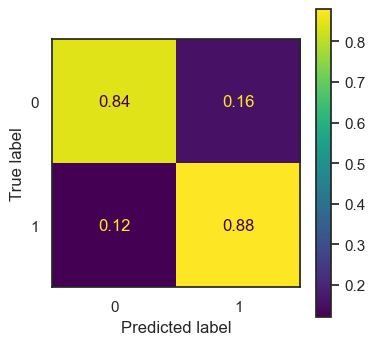

In [125]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(4, 4))

plot_confusion_matrix(nlp_model, X_test, y_test, normalize='true', ax=ax)

None

## Train to the whole dataset and predict our own reviews

In [126]:
vectorizer_final = TfidfVectorizer(lowercase=False) 
X = vectorizer_final.fit_transform(X)

parameters = {
    
    'loss' : ['modified_huber'],
    'penalty' : ['l2'],    
    'alpha' : [0.0001]
    
            }

sgd_final = GridSearchCV(SGDClassifier(n_jobs = -1, random_state = 0), parameters)
sgd_final.fit(X, y)

print('SGDClassifier')
scores = cross_val_score(sgd_final, X, y, cv=5)
print('cross validation score: ', round(scores.mean(), 2))

SGDClassifier
cross validation score:  0.86


In [127]:
def predict_review_df(df):

    df['review'] = df['review'].str.lower()
    df['review'] = df['review'].str.replace('<.*>', ' ') # remove html format
    df['review'] = df["review"].str.replace('https?://\S+|www\.\S+',' ') # remove urls
    df["review"] = df['review'].str.replace('[^a-z ]',' ') # keep characters and spaces
    df['review'] = df['review'].str.replace(' . ',' ') # remove single character between spaces
    df['review'] = df['review'].str.replace('\s+',' ').str.strip() # multiple spaces to one and remove side spaces
    
    data = df.copy()
    
    stop = stopwords.words('english')
    data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    lmtzr = WordNetLemmatizer()
    data['review'] = data['review'].apply(lambda x: ' '.join([lmtzr.lemmatize(word) for word in x.split()]))
    data['review'] = data['review'].str.split(" ")
    data['review'] = data['review'].apply(lambda x: ' '.join(x))

    X_test_data = data['review'].copy()
    X_test_data = vectorizer.transform(X_test_data)
    
    pred = nlp_model.predict_proba(X_test_data)
    df_final = pd.DataFrame(pred).rename(columns={0:'Negative_prob', 1:'Positive_prob'})
    df_final = df.merge(df_final, left_index=True, right_index=True)

    return df_final    

In [130]:
dict_review = {'review':[
                       'Blablabla 234 bad movie',
                       'This was the best movie ever',
                       'This movie is the best but we are trying very bad to mislead our model',
                       'blablabla blablabla'
                      ]}

In [131]:
df_my_reviews = pd.DataFrame(dict_review)
df_my_reviews = predict_review_df(df_my_reviews)
df_my_reviews

,review,Negative_prob,Positive_prob
0,blablabla bad movie,0.875775,0.124225
1,this was the best movie ever,0.000000,1.000000
2,this movie is the best but we are trying very bad to mislead our model,0.919170,0.080830
3,blablabla blablabla,0.547528,0.452472
